<a href="https://colab.research.google.com/github/rikunemu/colab_study/blob/main/pose_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  mediapipeで取ったposeの特徴点を分析

90分対策  
F12を開いて以下のスクリプトをコンソールで実行  
function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,600000)

  
10分ごとに接続

参考url:
https://sunnyday-travel-aso-6487.ssl-lolipop.jp/programing/python/keras/lstm-use/

In [1]:
import sys
from google.colab import drive
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import csv
import os
import keras
from keras import models
from keras.models import Sequential, load_model
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils as np_utils
from keras.utils.np_utils import to_categorical
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
drive.mount("/content/drive")

Mounted at /content/drive


## csvデータ読み込み
train,test,validそれぞれ7感情の特徴点を記録

In [2]:
fp_train='/content/drive/MyDrive/data分析/join_csv/csvtrainresult.csv'
df_train=pd.read_csv(fp_train)
fp_test='/content/drive/MyDrive/data分析/join_csv/csvtestresult.csv'
df_test=pd.read_csv(fp_test)

Unnameはいらないので削除

In [3]:
df_test=df_test.replace('NAN',0.1)
df_train=df_train.replace('NAN',0.1)

In [4]:
df_train=df_train.drop(columns=df_train.columns[[0]],axis=1)

In [5]:
df_test=df_test.drop(columns=df_test.columns[[0]],axis=1)

In [6]:
df_train=df_train.fillna(0.1)
df_test=df_test.fillna(0.1)

それぞれのデータを目的変数と説明変数に分ける

In [7]:
x_train=DataFrame(df_train.drop("correct",axis=1)).values
Y_train=DataFrame(df_train["correct"]-1).values
x_test=DataFrame(df_test.drop("correct",axis=1)).values
Y_test=DataFrame(df_test["correct"]-1).values

X_test = np.array(x_test).reshape(200, 30,162)
Y_test = np.array(Y_test[::30]).reshape(200)
y_test = np_utils.to_categorical(Y_test,20)
y_test = y_test.astype(np.float)
X_test = X_test.astype(np.float)

In [8]:
def build_model(maxlen):
  model = Sequential()
  model.add(LSTM(64, return_sequences=False, activation='relu', input_shape=(30,maxlen)))
  """
  model.add(Dropout(0.1))
  model.add(LSTM(128, return_sequences=True, activation='relu'))
  model.add(Dropout(0.1))
  model.add(LSTM(64, return_sequences=False, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  """
  model.add(Dense(20, activation='softmax'))
  adam = Adam(learning_rate=1e-4)
  model.compile(optimizer=adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [9]:
def plot_history(history):
    # print(history.history.keys())

    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()
    plt.close()

In [10]:
def cmd_pose(Y_test,y_pred):
  cm = confusion_matrix(Y_test, y_pred)
  #表示
  cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  fig, ax = plt.subplots(figsize=(10, 10))
  cmd.plot(ax=ax, cmap="Blues")
  plt.show()
  plt.close()
  return

fold 0 score: [0.927806556224823, 0.7900000214576721]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.62      0.50      0.56        10
           2       1.00      0.70      0.82        10
           3       0.73      0.80      0.76        10
           4       1.00      0.80      0.89        10
           5       0.50      0.40      0.44        10
           6       0.75      0.90      0.82        10
           7       0.88      0.70      0.78        10
           8       0.80      0.80      0.80        10
           9       0.82      0.90      0.86        10
          10       0.73      0.80      0.76        10
          11       1.00      0.80      0.89        10
          12       0.64      0.90      0.75        10
          13       0.91      1.00      0.95        10
          14       1.00      0.40      0.57        10
          15       0.82      0.90      0.86        10
          16       0.89      0.80      0.84        10
          17       0.77      1.00      0.87        10
          18       0.67    

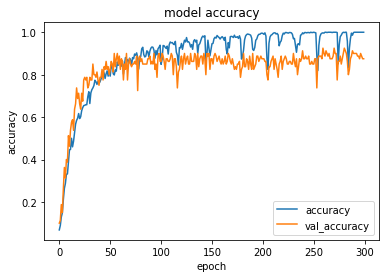

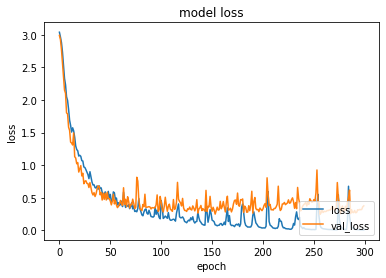

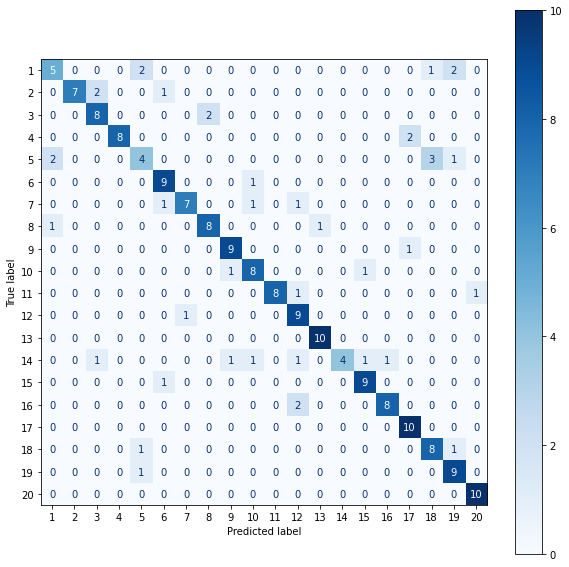

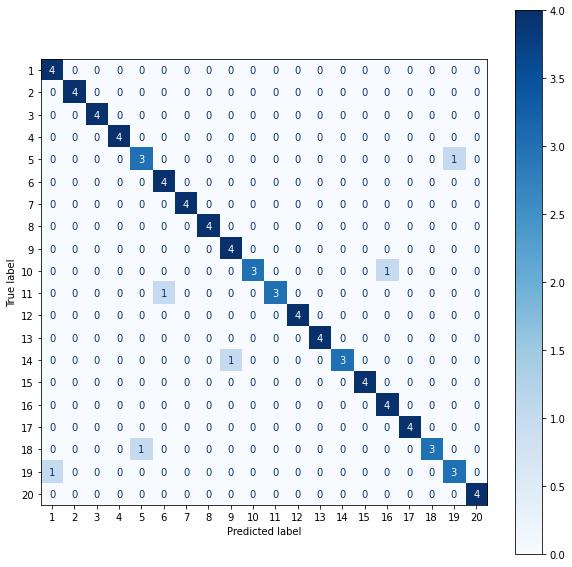

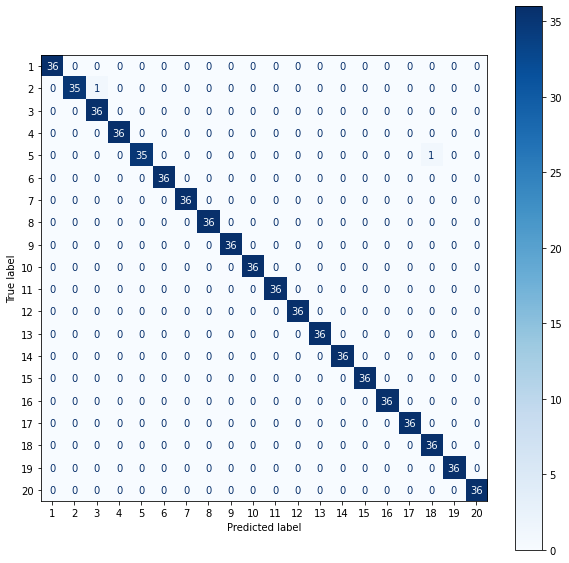

fold 1 score: [0.7929733991622925, 0.7950000166893005]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       1.00      0.50      0.67        10
           2       0.89      0.80      0.84        10
           3       0.70      0.70      0.70        10
           4       0.83      1.00      0.91        10
           5       0.62      0.80      0.70        10
           6       1.00      1.00      1.00        10
           7       0.62      0.80      0.70        10
           8       0.62      0.50      0.56        10
           9       1.00      0.60      0.75        10
          10       0.67      1.00      0.80        10
          11       1.00      0.80      0.89        10
          12       1.00      0.60      0.75        10
          13       0.67      1.00      0.80        10
          14       0.50      0.60      0.55        10
          15       0.89      0.80      0.84        10
          16       1.00      1.00      1.00        10
          17       1.00      0.70      0.82        10
          18       0.78    

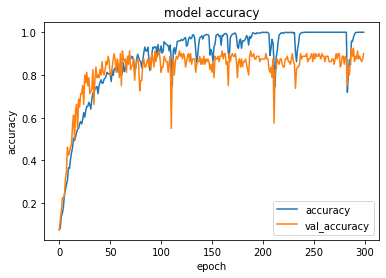

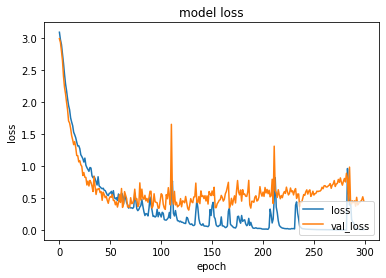

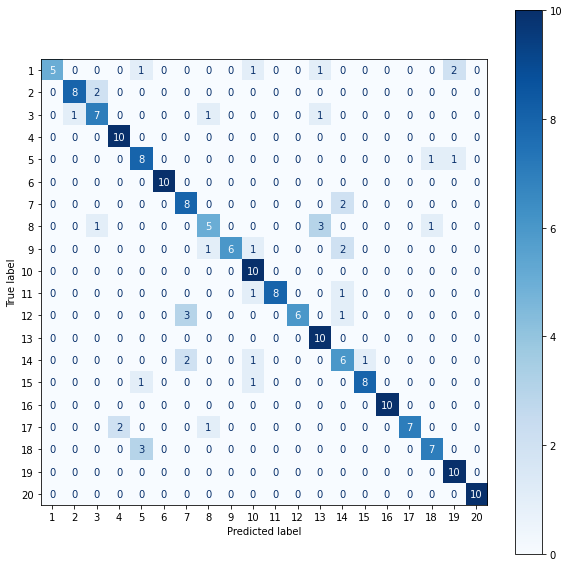

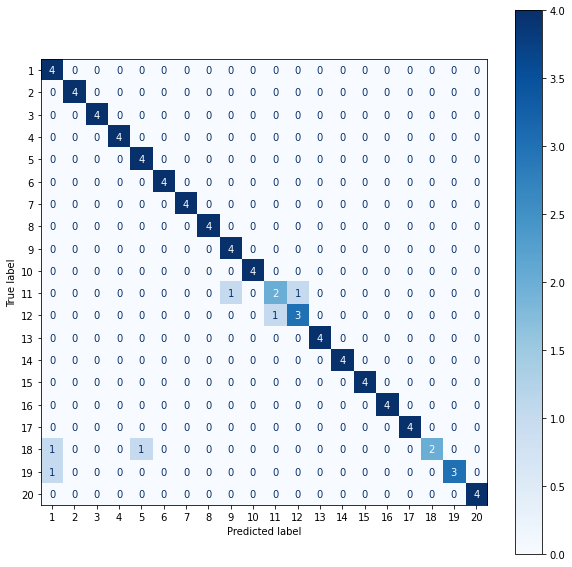

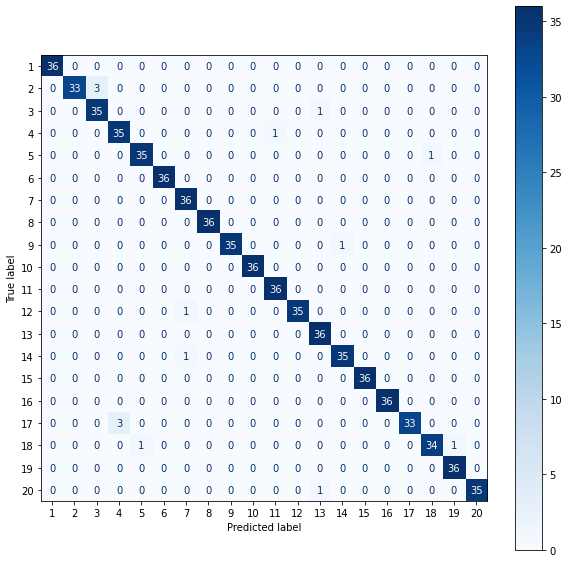

fold 2 score: [1.1493964195251465, 0.7599999904632568]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.71      0.50      0.59        10
           2       0.83      0.50      0.62        10
           3       0.58      0.70      0.64        10
           4       1.00      0.90      0.95        10
           5       0.57      0.40      0.47        10
           6       0.83      1.00      0.91        10
           7       0.73      0.80      0.76        10
           8       0.67      0.80      0.73        10
           9       0.83      0.50      0.62        10
          10       0.89      0.80      0.84        10
          11       0.64      0.90      0.75        10
          12       0.78      0.70      0.74        10
          13       0.88      0.70      0.78        10
          14       0.25      0.30      0.27        10
          15       1.00      1.00      1.00        10
          16       0.91      1.00      0.95        10
          17       0.91      1.00      0.95        10
          18       0.82    

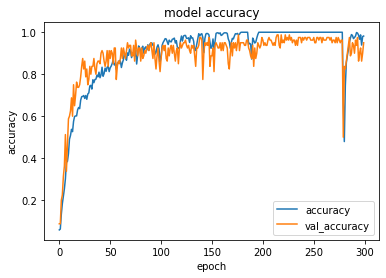

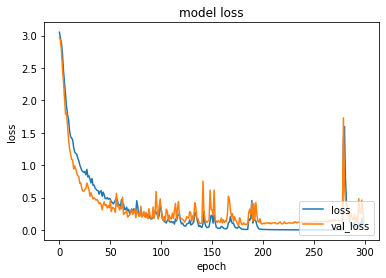

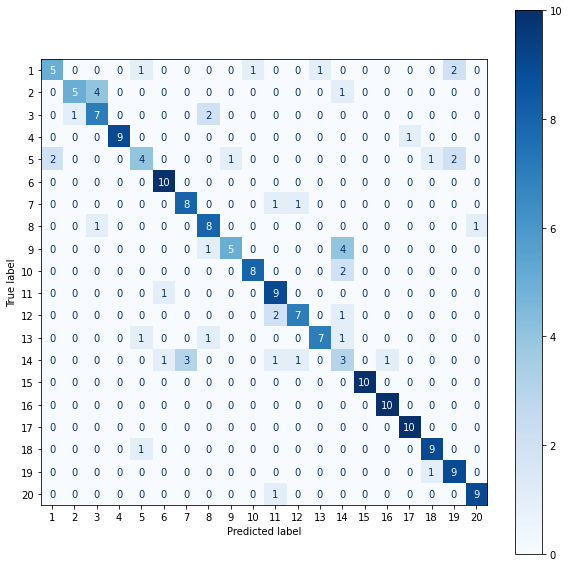

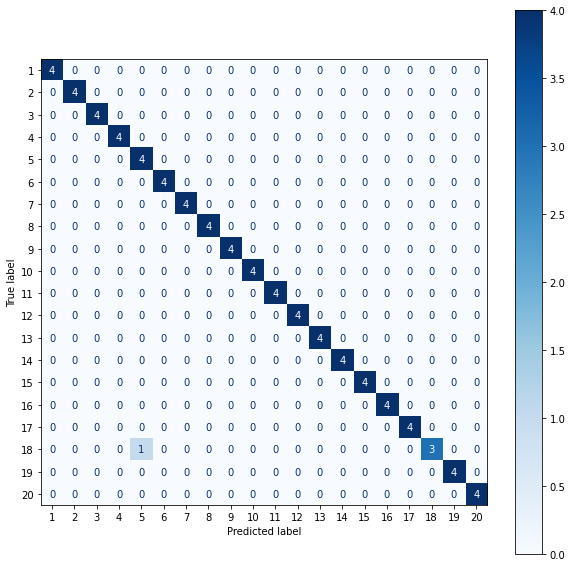

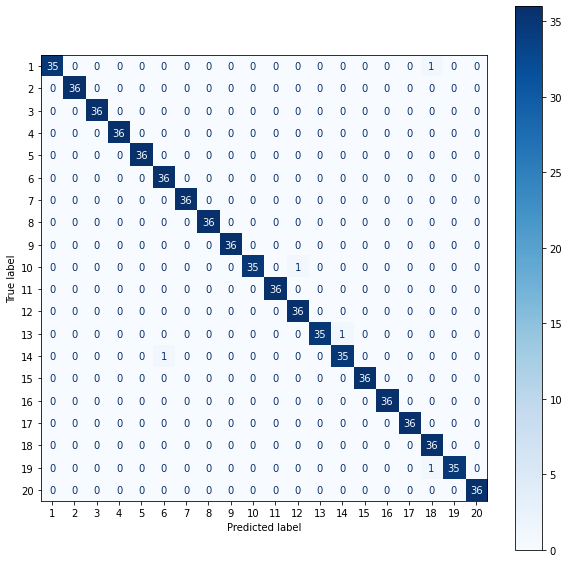

fold 3 score: [0.9459386467933655, 0.7749999761581421]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.86      0.60      0.71        10
           2       0.75      0.90      0.82        10
           3       0.80      0.40      0.53        10
           4       1.00      0.70      0.82        10
           5       0.67      0.60      0.63        10
           6       0.91      1.00      0.95        10
           7       0.77      1.00      0.87        10
           8       0.50      0.60      0.55        10
           9       0.78      0.70      0.74        10
          10       0.64      0.90      0.75        10
          11       1.00      0.90      0.95        10
          12       0.67      0.60      0.63        10
          13       0.91      1.00      0.95        10
          14       0.50      0.10      0.17        10
          15       0.82      0.90      0.86        10
          16       0.83      1.00      0.91        10
          17       0.71      1.00      0.83        10
          18       0.75    

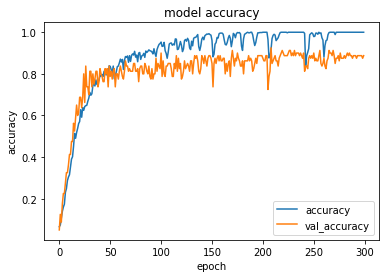

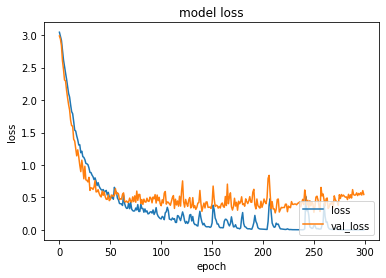

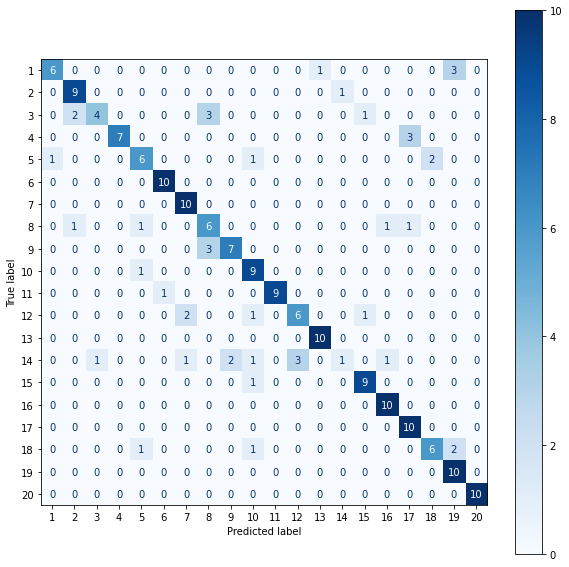

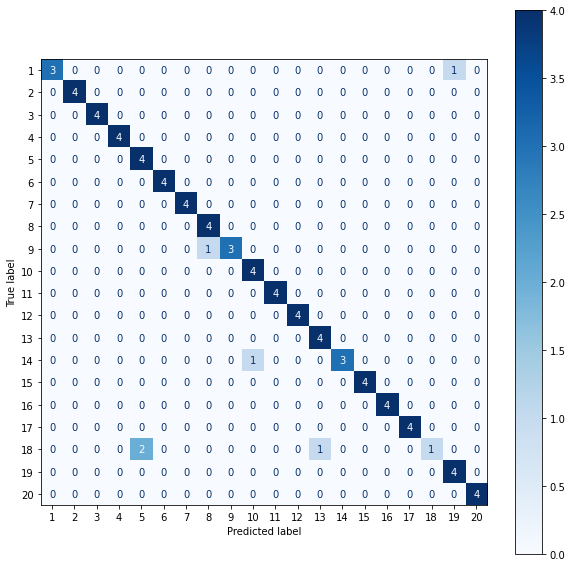

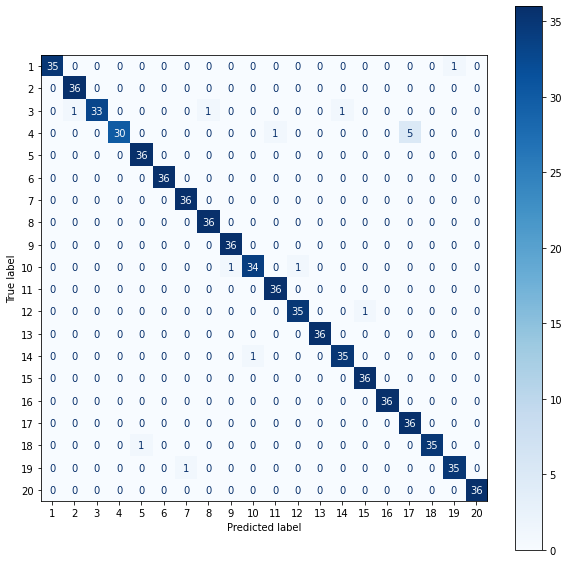

fold 4 score: [0.7425112724304199, 0.824999988079071]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.64      0.70      0.67        10
           2       0.71      1.00      0.83        10
           3       0.88      0.70      0.78        10
           4       0.82      0.90      0.86        10
           5       1.00      0.60      0.75        10
           6       1.00      0.90      0.95        10
           7       0.70      0.70      0.70        10
           8       1.00      0.70      0.82        10
           9       0.86      0.60      0.71        10
          10       0.71      1.00      0.83        10
          11       0.90      0.90      0.90        10
          12       0.88      0.70      0.78        10
          13       0.91      1.00      0.95        10
          14       0.60      0.90      0.72        10
          15       1.00      0.90      0.95        10
          16       1.00      0.70      0.82        10
          17       0.89      0.80      0.84        10
          18       0.67    

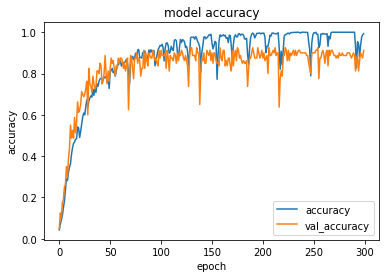

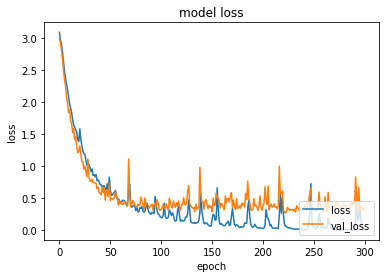

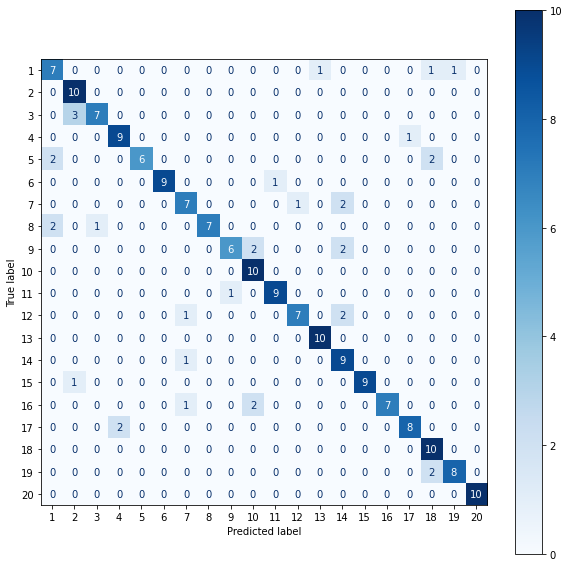

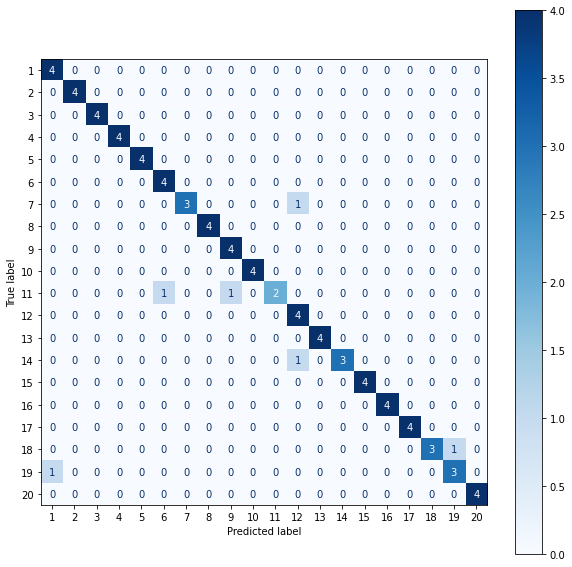

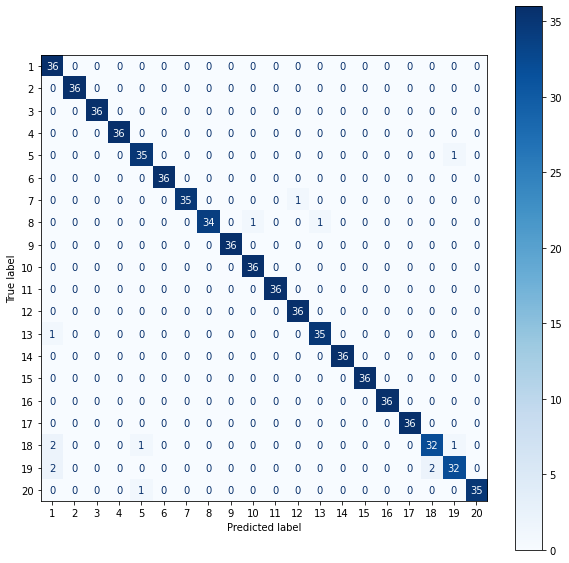

fold 5 score: [0.650643527507782, 0.7900000214576721]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.71      0.50      0.59        10
           2       0.80      0.80      0.80        10
           3       0.78      0.70      0.74        10
           4       1.00      0.70      0.82        10
           5       1.00      0.60      0.75        10
           6       0.91      1.00      0.95        10
           7       0.83      0.50      0.62        10
           8       0.60      0.90      0.72        10
           9       1.00      0.50      0.67        10
          10       0.75      0.90      0.82        10
          11       0.69      0.90      0.78        10
          12       0.67      0.60      0.63        10
          13       0.91      1.00      0.95        10
          14       0.73      0.80      0.76        10
          15       1.00      0.90      0.95        10
          16       0.90      0.90      0.90        10
          17       0.77      1.00      0.87        10
          18       0.59    

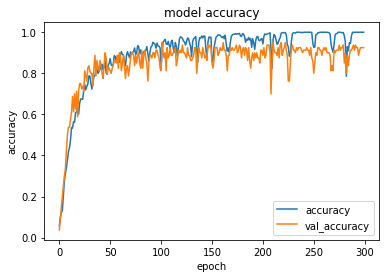

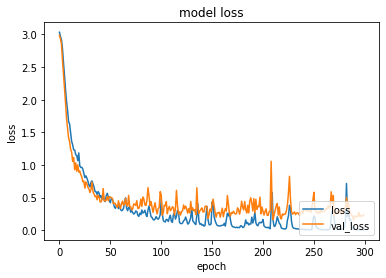

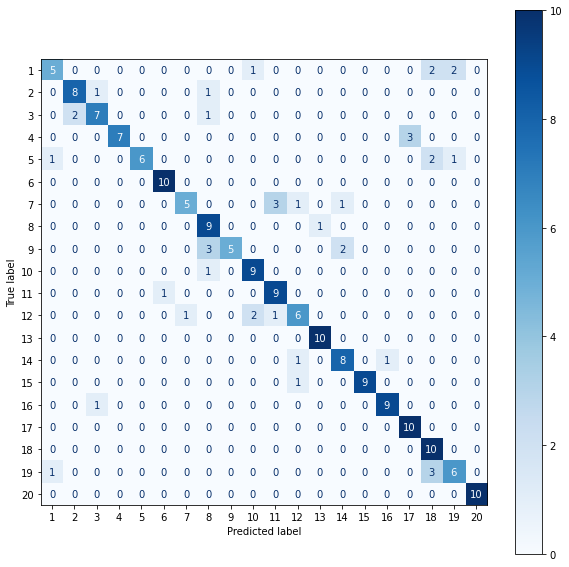

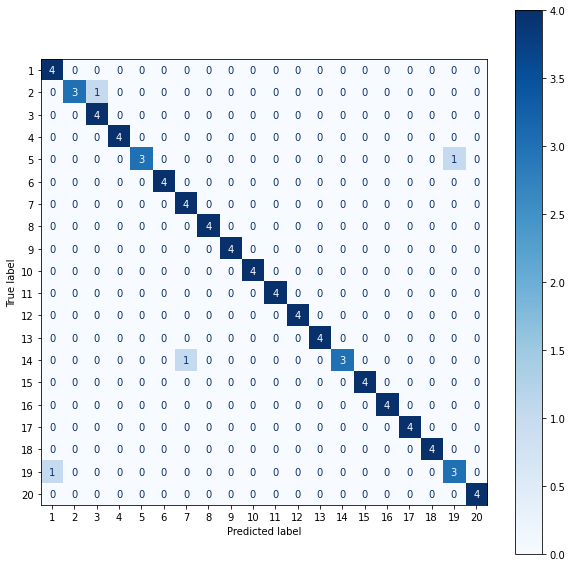

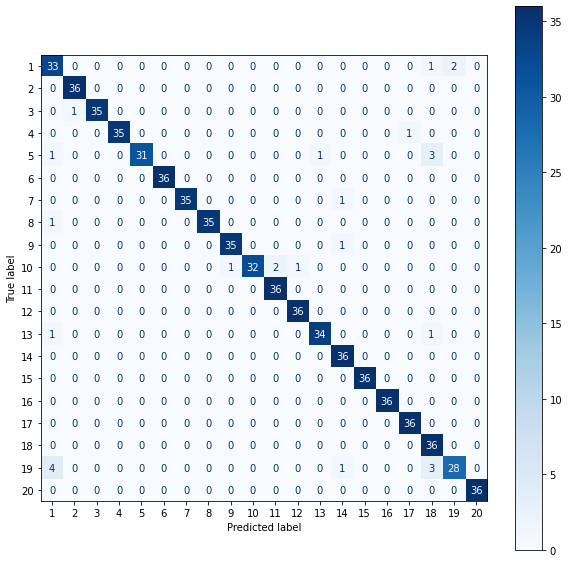

fold 6 score: [1.1886115074157715, 0.8399999737739563]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.88      0.70      0.78        10
           2       1.00      0.50      0.67        10
           3       0.57      0.80      0.67        10
           4       1.00      1.00      1.00        10
           5       0.82      0.90      0.86        10
           6       0.83      1.00      0.91        10
           7       0.67      0.80      0.73        10
           8       0.62      0.80      0.70        10
           9       0.88      0.70      0.78        10
          10       1.00      1.00      1.00        10
          11       0.90      0.90      0.90        10
          12       0.78      0.70      0.74        10
          13       1.00      0.90      0.95        10
          14       0.75      0.60      0.67        10
          15       0.86      0.60      0.71        10
          16       0.91      1.00      0.95        10
          17       0.82      0.90      0.86        10
          18       0.91    

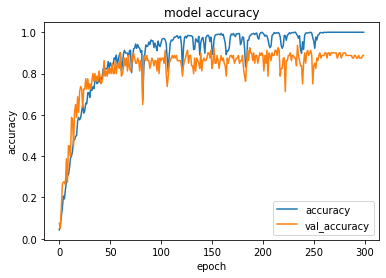

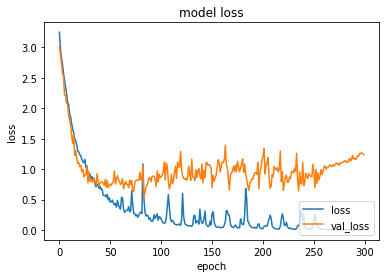

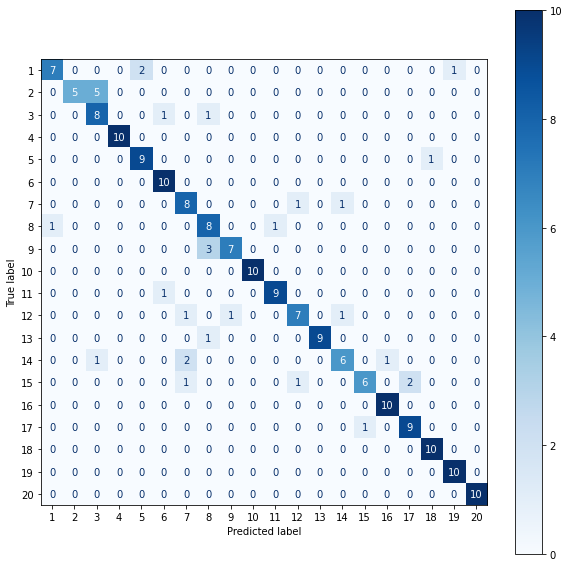

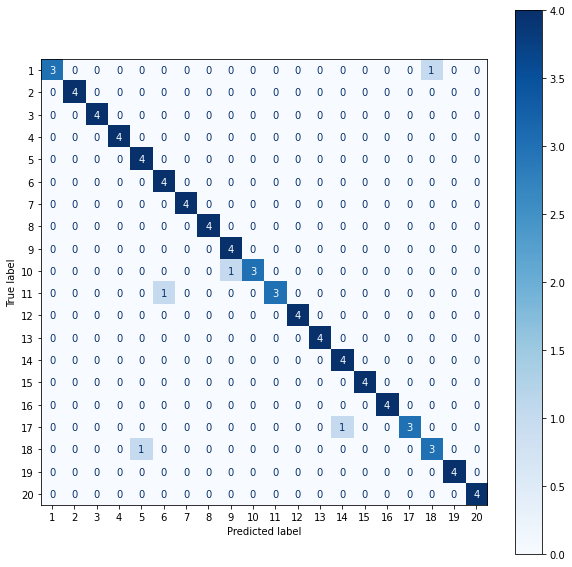

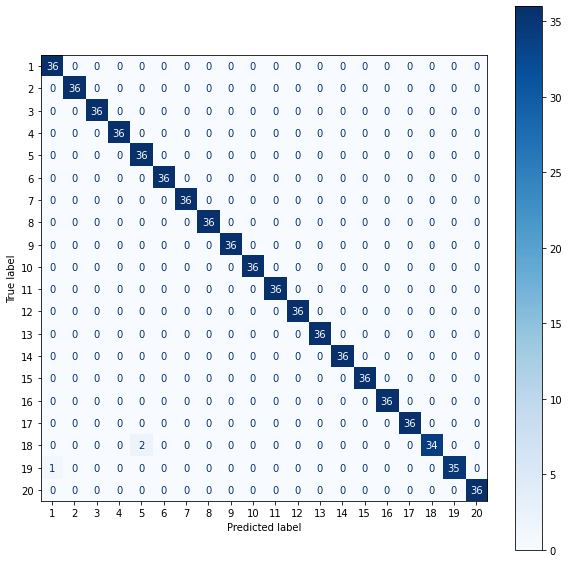

fold 7 score: [0.8395484685897827, 0.7699999809265137]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.62      0.50      0.56        10
           2       0.60      0.60      0.60        10
           3       0.64      0.70      0.67        10
           4       0.88      0.70      0.78        10
           5       0.78      0.70      0.74        10
           6       0.91      1.00      0.95        10
           7       0.73      0.80      0.76        10
           8       0.82      0.90      0.86        10
           9       0.62      0.80      0.70        10
          10       0.73      0.80      0.76        10
          11       1.00      0.90      0.95        10
          12       0.57      0.40      0.47        10
          13       0.77      1.00      0.87        10
          14       0.78      0.70      0.74        10
          15       1.00      0.80      0.89        10
          16       0.89      0.80      0.84        10
          17       0.83      1.00      0.91        10
          18       0.60    

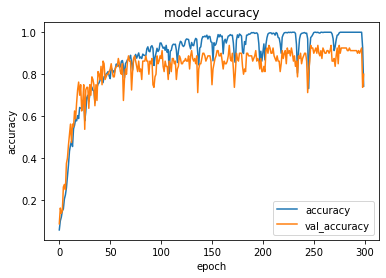

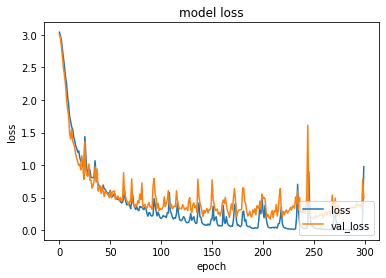

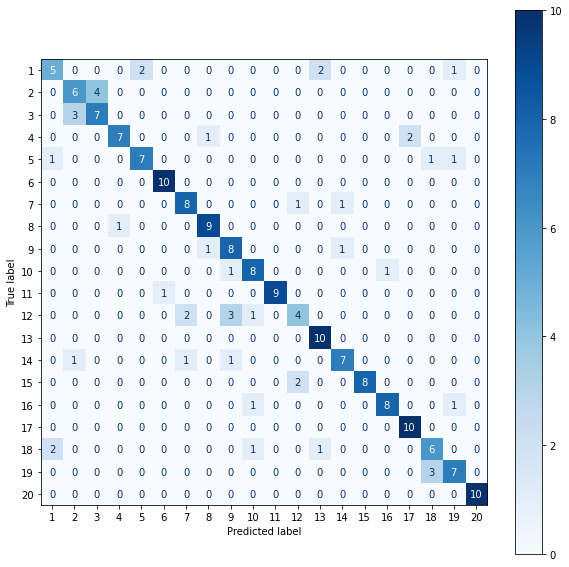

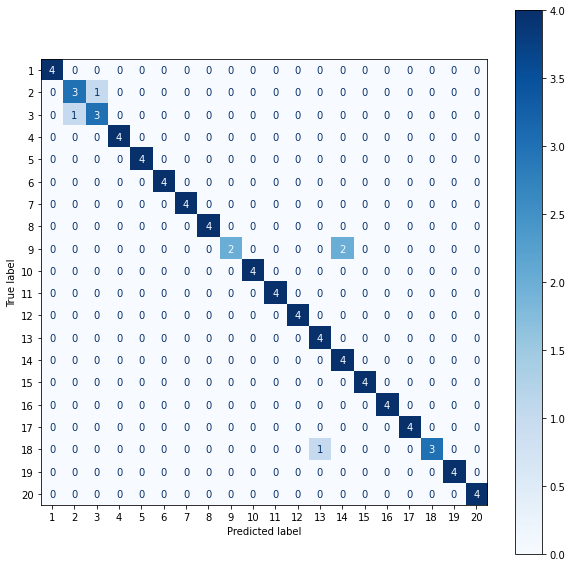

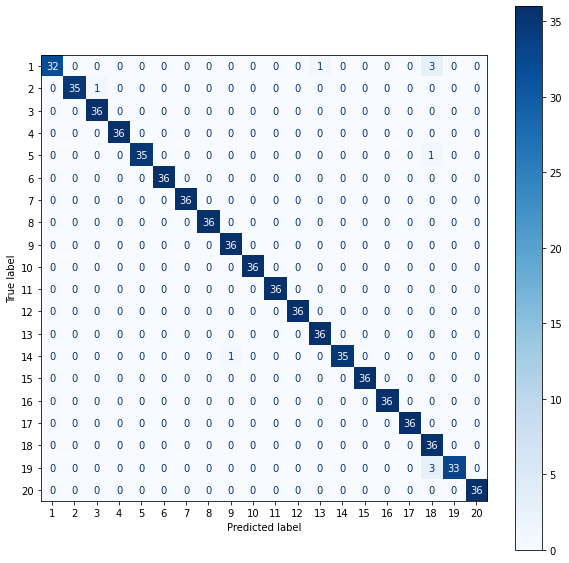

fold 8 score: [1.0387635231018066, 0.8050000071525574]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.64      0.70      0.67        10
           2       0.71      0.50      0.59        10
           3       0.58      0.70      0.64        10
           4       1.00      1.00      1.00        10
           5       0.75      0.30      0.43        10
           6       1.00      1.00      1.00        10
           7       0.83      0.50      0.62        10
           8       0.80      0.80      0.80        10
           9       1.00      0.70      0.82        10
          10       0.82      0.90      0.86        10
          11       0.69      0.90      0.78        10
          12       0.88      0.70      0.78        10
          13       0.91      1.00      0.95        10
          14       0.67      0.80      0.73        10
          15       1.00      1.00      1.00        10
          16       0.91      1.00      0.95        10
          17       1.00      1.00      1.00        10
          18       0.62    

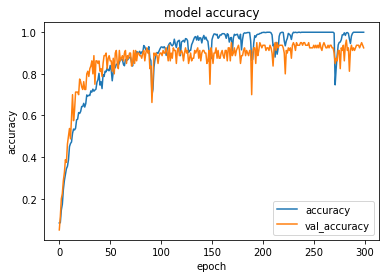

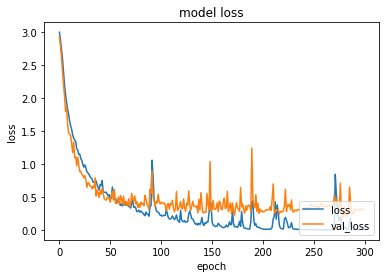

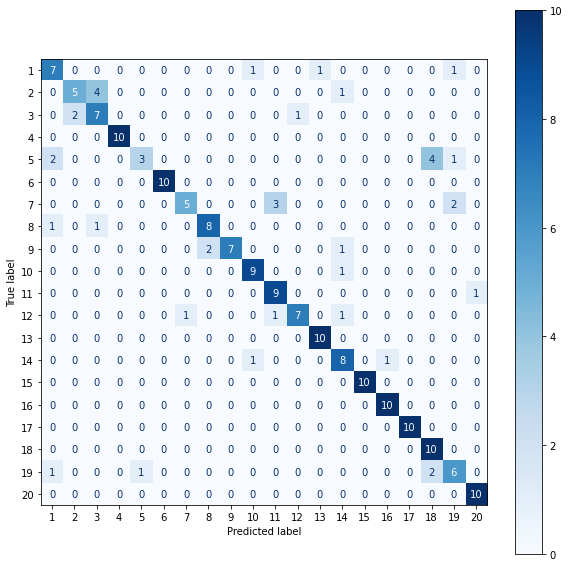

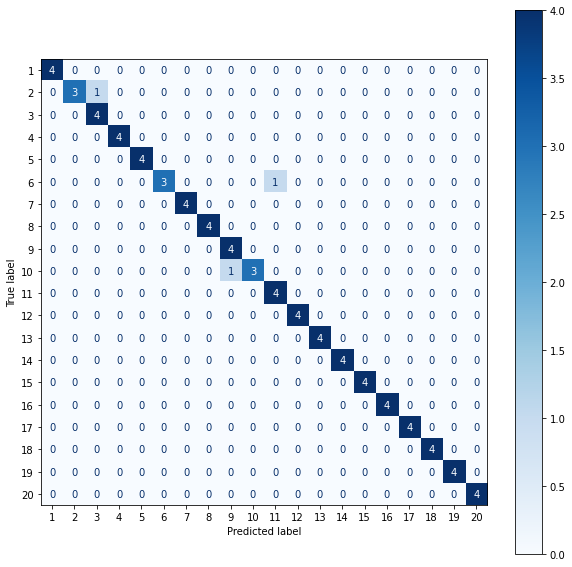

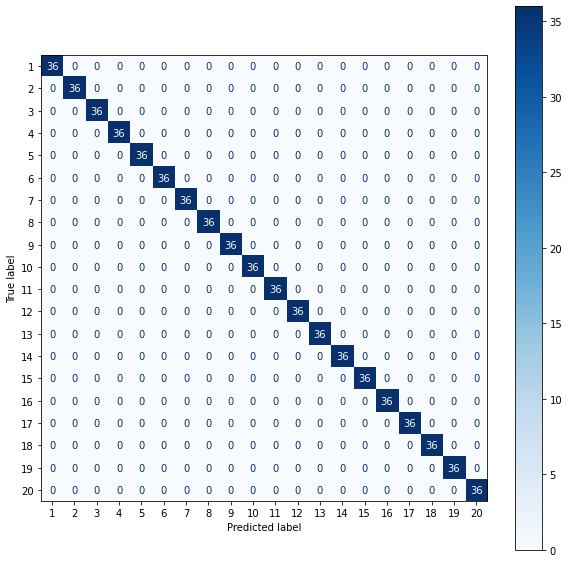

fold 9 score: [1.2782925367355347, 0.7549999952316284]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.56      0.50      0.53        10
           2       0.71      1.00      0.83        10
           3       0.86      0.60      0.71        10
           4       0.90      0.90      0.90        10
           5       0.62      0.80      0.70        10
           6       0.90      0.90      0.90        10
           7       0.75      0.90      0.82        10
           8       0.64      0.70      0.67        10
           9       0.60      0.30      0.40        10
          10       0.70      0.70      0.70        10
          11       0.90      0.90      0.90        10
          12       0.67      0.60      0.63        10
          13       0.89      0.80      0.84        10
          14       0.36      0.40      0.38        10
          15       1.00      0.90      0.95        10
          16       0.89      0.80      0.84        10
          17       0.80      0.80      0.80        10
          18       0.82    

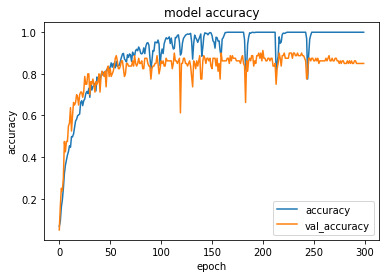

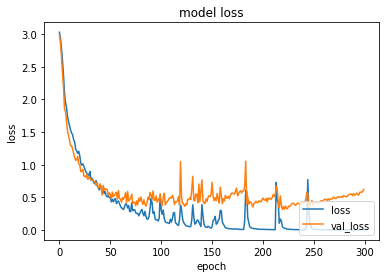

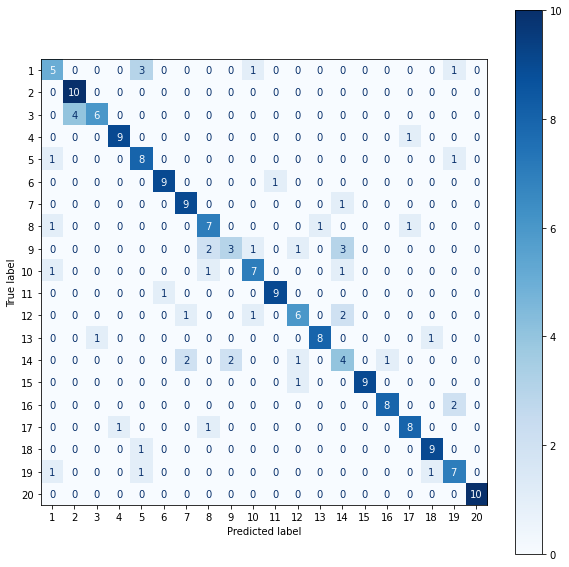

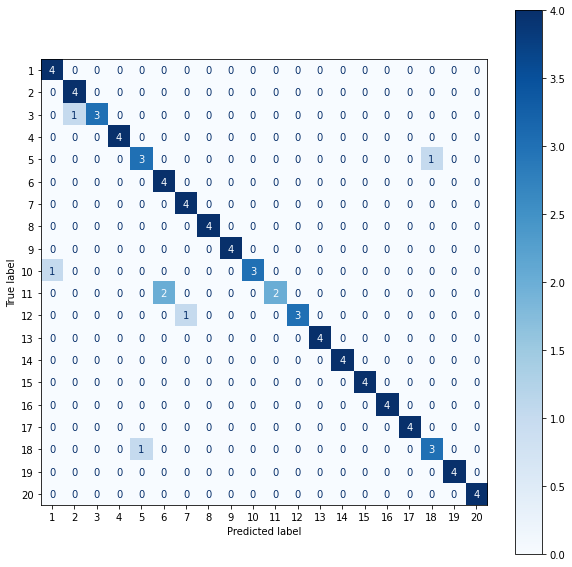

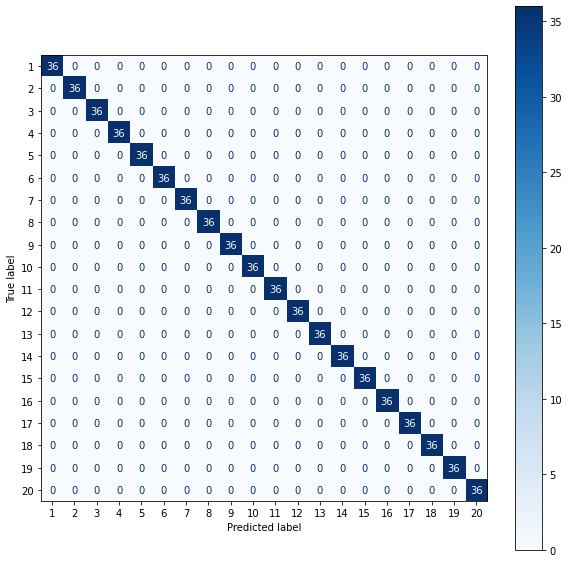

CV score: 0.790499997138977


In [11]:
FOLD = 10
EPOCH = 300
BATCH_SIZE = 16

valid_scores = []
models = []
kf = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=42)

for fold, (train_indices, valid_indices) in enumerate(kf.split(x_train, Y_train)):
    X_train, X_valid = x_train[train_indices], x_train[valid_indices]
    y_train, y_valid = Y_train[train_indices], Y_train[valid_indices]
    

    X_train = np.array(X_train).reshape(720, 30, 162)
    X_valid = np.array(X_valid).reshape(80, 30,162)
    Y1_train = np.array(y_train[::30]).reshape(720)
    Y1_valid = np.array(y_valid[::30]).reshape(80)
    y_train = np_utils.to_categorical(Y1_train,20)
    y_valid = np_utils.to_categorical(Y1_valid,20)

    X_train = X_train.astype(np.float)
    X_valid = X_valid.astype(np.float)
    y_train = y_train.astype(np.float)
    y_valid = y_valid.astype(np.float)
    model = build_model(X_train.shape[2])

    modelCheckpoint = ModelCheckpoint(filepath ='/content/drive/MyDrive/data分析/join_csv/lstm_cross.hdf5',
                                  monitor='val_accuracy',
                                  verbose=0,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='max',
                                  period=1)

    history=model.fit(X_train, y_train,
              validation_data=(X_valid, y_valid),
              epochs=EPOCH,
              batch_size=BATCH_SIZE,
              callbacks=[modelCheckpoint],
              verbose=0)
    
    model2=load_model('/content/drive/MyDrive/data分析/join_csv/lstm_cross.hdf5')
    score = model2.evaluate(X_test,y_test,verbose=0)
    print(f'fold {fold} score: {score}')
    valid_scores.append(score[1])
    Y_pred = model2.predict_generator(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_otamesi = model2.predict_generator(X_valid)
    y_otamesi = np.argmax(Y_otamesi, axis=1)
    Y_otamesi1 = model2.predict_generator(X_train)
    y_otamesi1 = np.argmax(Y_otamesi1, axis=1)
    labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9","10","11","12","13","14","15","16","17", "18", "19", "20"]
    
    report = metrics.classification_report(Y_test,y_pred, 
                                       labels=np.arange(len(labels)),
                                       target_names=labels)
    print(report)
    # 学習履歴をプロット
    plot_history(history)
    cmd_pose(Y_test,y_pred)
    cmd_pose(Y1_valid,y_otamesi)
    cmd_pose(Y1_train,y_otamesi1)
    models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')
